# K-Means Clustering (Races)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

This notebook study the application of the K-Means clustering algorithm on races data.

The approach below includes in the clustering process the 6 features `points`, `length`, `climb_total`, `race_physical_effort`, `race_prestige` and `num_participants`.

The selection of these features was derived from a data understanding process, applied following the data cleaning and feature engeneering phases, through which it was possible to skim the attributes by identifying those that appeared to be the most significant. In particular, thanks to the data representation process (applying UMAP and PCA) these feature emerged as the most "aligned" with the principal components.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import itertools

In [3]:
races_dataset = pd.read_csv('../../data/races_dataset_no_outliers.csv').drop(['uci_points', 'profile'], axis=1)
races_dataset = races_dataset.select_dtypes(include=['number'])
races_dataset = races_dataset.dropna().reset_index(drop=True)

# Drop colums from PCA and UMAP analisis
races_dataset = races_dataset.drop(['startlist_quality', 'race_year', 'climb_percentage'], axis=1)

races_dataset.info()
columns_to_use = races_dataset.columns

# Standardization of the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(races_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2841 entries, 0 to 2840
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2841 non-null   float64
 1   length                2841 non-null   float64
 2   climb_total           2841 non-null   float64
 3   race_physical_effort  2841 non-null   float64
 4   race_prestige         2841 non-null   float64
 5   num_participants      2841 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 133.3 KB


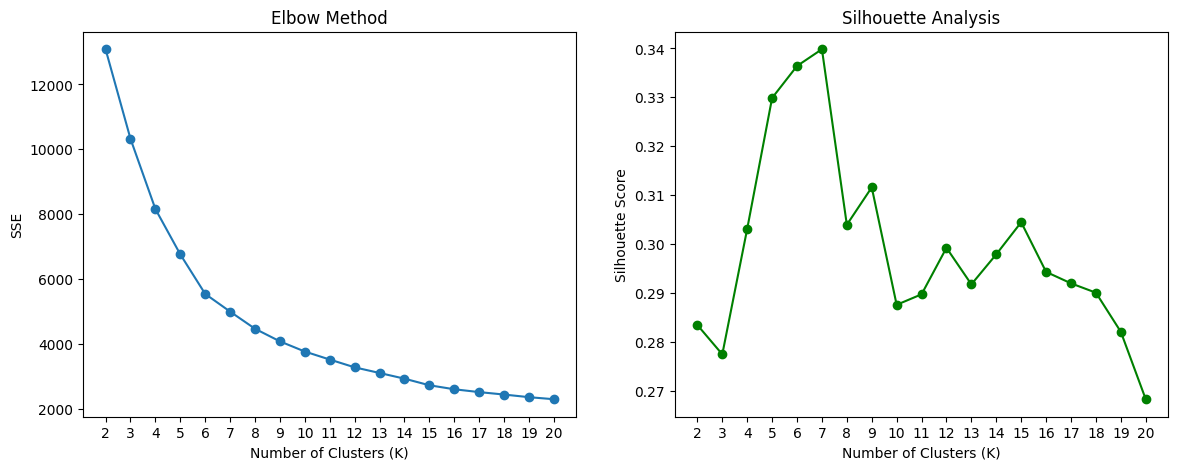

In [4]:
sse_list = []
silhouette_scores = []
max_k = 20

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(data_scaled)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Visualize the Elbow Method
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), sse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.xticks(range(2, max_k+1))
plt.ylabel('SSE')
plt.title('Elbow Method')

# Visualize the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (K)')
plt.xticks(range(2, max_k+1))
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

For the determination of the optimal number of clusters, we considered both the Elbow Method and the Silhouette Score. By analyzing both metrics, we observed that the most suitable number of clusters for our dataset is 6. This choice balances the compactness and separation of the clusters, expecting meaningful and interpretable results.

In [5]:
# Apply K-Means
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42)
kmeans.fit(data_scaled)

KMeans(max_iter=100, n_clusters=6, n_init=10, random_state=42)

In [6]:
cluster_labels = kmeans.labels_ # Cluster labels
centers = kmeans.cluster_centers_ # Cluster centroids

races_dataset['cluster'] = cluster_labels # Add cluster labels to the original dataset

print(f"SSE (Sum of Squared Errors): {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(data_scaled, cluster_labels)}")

SSE (Sum of Squared Errors): 5541.198868779502
Silhouette Score: 0.33640910980215627


#### 2D Clusters

In [7]:
def plot_variable_pairs(columns_to_use, dataset):
    """
    Plot all possible pairs of variables in a dataset

    Parameters
        - columns_to_use: list of columns to use
        - dataset: dataset to use
    """

    pairs = list(itertools.combinations(columns_to_use, 2)) # Create all possible pairs of variables
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

    # if there is only one row of subplots, axes will be a 1D array
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    columns_to_use_list = list(columns_to_use)

    # Plot for each pair of variables
    for (x_var, y_var), ax in zip(pairs, axes.ravel()):
        sns.scatterplot(
            data=dataset,
            x=x_var, y=y_var, hue="cluster", palette="viridis", ax=ax, s=10
        )
        ax.scatter(
            scaler.inverse_transform(centers)[:, columns_to_use_list.index(x_var)],
            scaler.inverse_transform(centers)[:, columns_to_use_list.index(y_var)],
            s=200, c='red', marker='*', label='Centroids'
        )
        ax.set_title(f'Clusters: {x_var} vs {y_var}')
        ax.legend()

    # Remove empty subplots if n_pairs does not fill the grid
    for ax in axes.ravel()[n_pairs:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

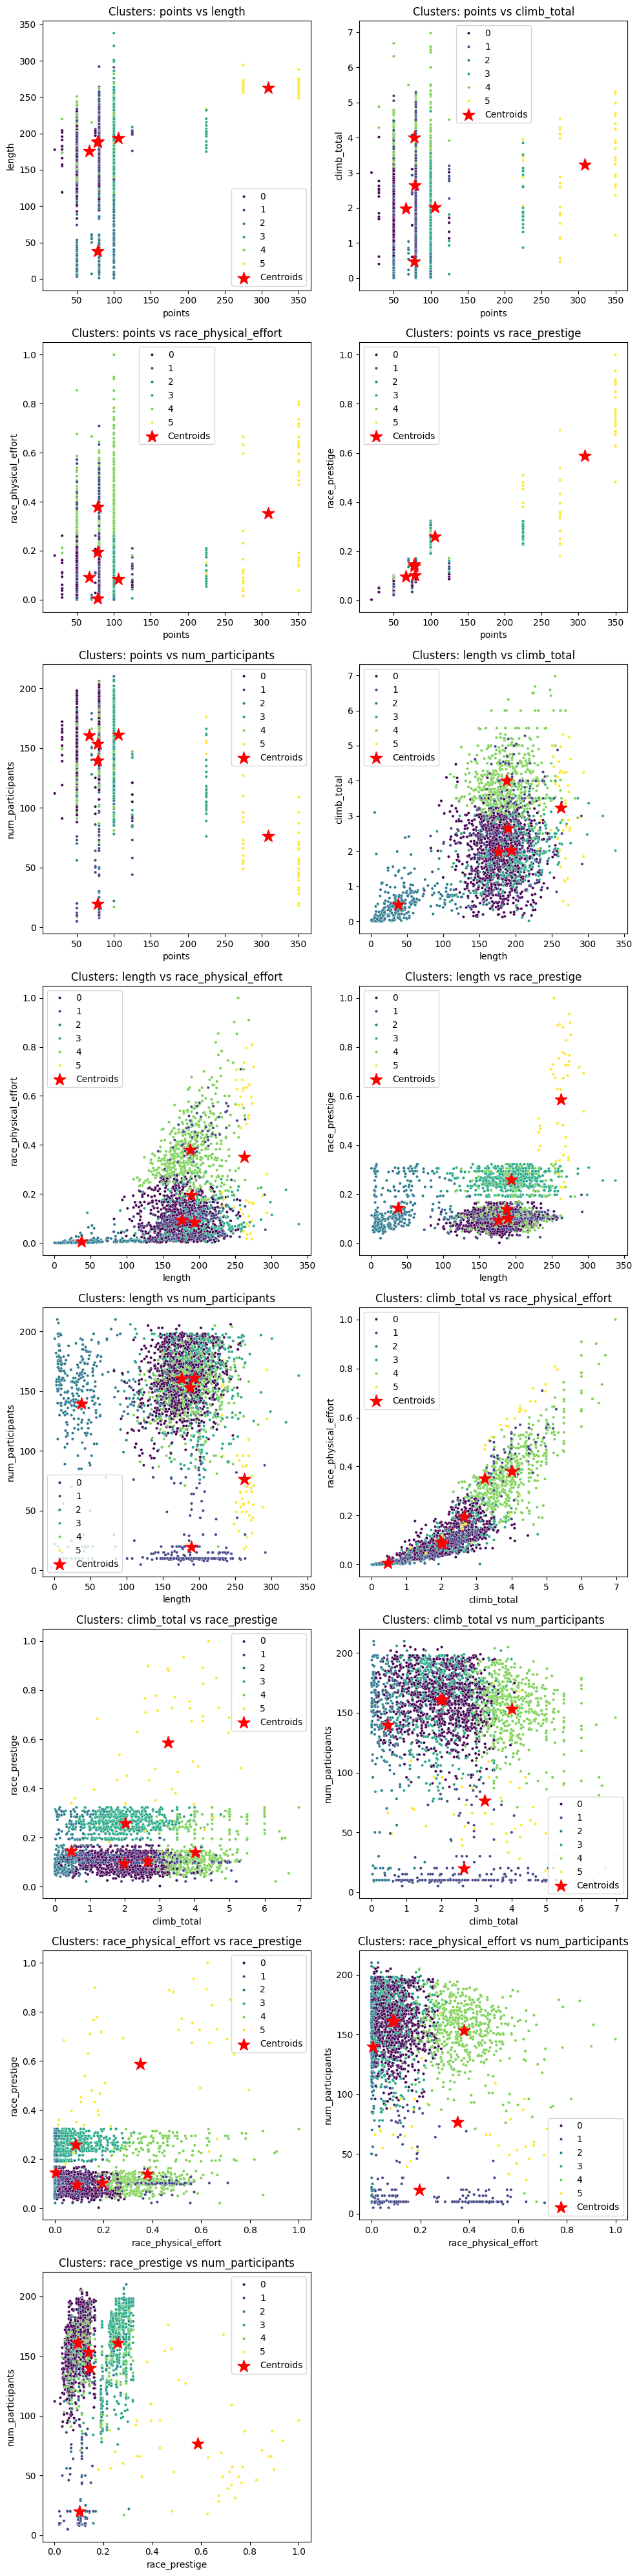

In [8]:
plot_variable_pairs(columns_to_use, races_dataset)

#### 3D Clusters

In [17]:
def plot_variable_triplets(columns_to_use, dataset):
    """
    Plot all possible triplets of variables in a dataset

    Parameters
        - columns_to_use: list of columns to use
        - dataset: dataset to use
    """

    triplets = list(itertools.combinations(columns_to_use, 3)) # Create all possible triplets of variables
    n_triplets = len(triplets)
    n_cols = 2
    n_rows = int(np.ceil(n_triplets / n_cols))

    fig = plt.figure(figsize=(14, 7 * n_rows))

    columns_to_use_list = list(columns_to_use)

    # Plot for each combination of three variables
    for i, (x_var, y_var, z_var) in enumerate(triplets):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        # Plot of the data
        ax.scatter(
            dataset[x_var],
            dataset[y_var],
            dataset[z_var],
            c=dataset["cluster"], cmap="viridis", s=10, zorder=1
        )

        # Plot of the centroids
        for center in scaler.inverse_transform(centers):
            ax.scatter(
            center[columns_to_use_list.index(x_var)],
            center[columns_to_use_list.index(y_var)],
            center[columns_to_use_list.index(z_var)],
            s=200, c='red', marker='*', zorder=2
            )

        ax.set_title(f'Clusters: {x_var} vs {y_var} vs {z_var}', pad=20)
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
        ax.set_zlabel(z_var)

    plt.tight_layout()
    plt.show()

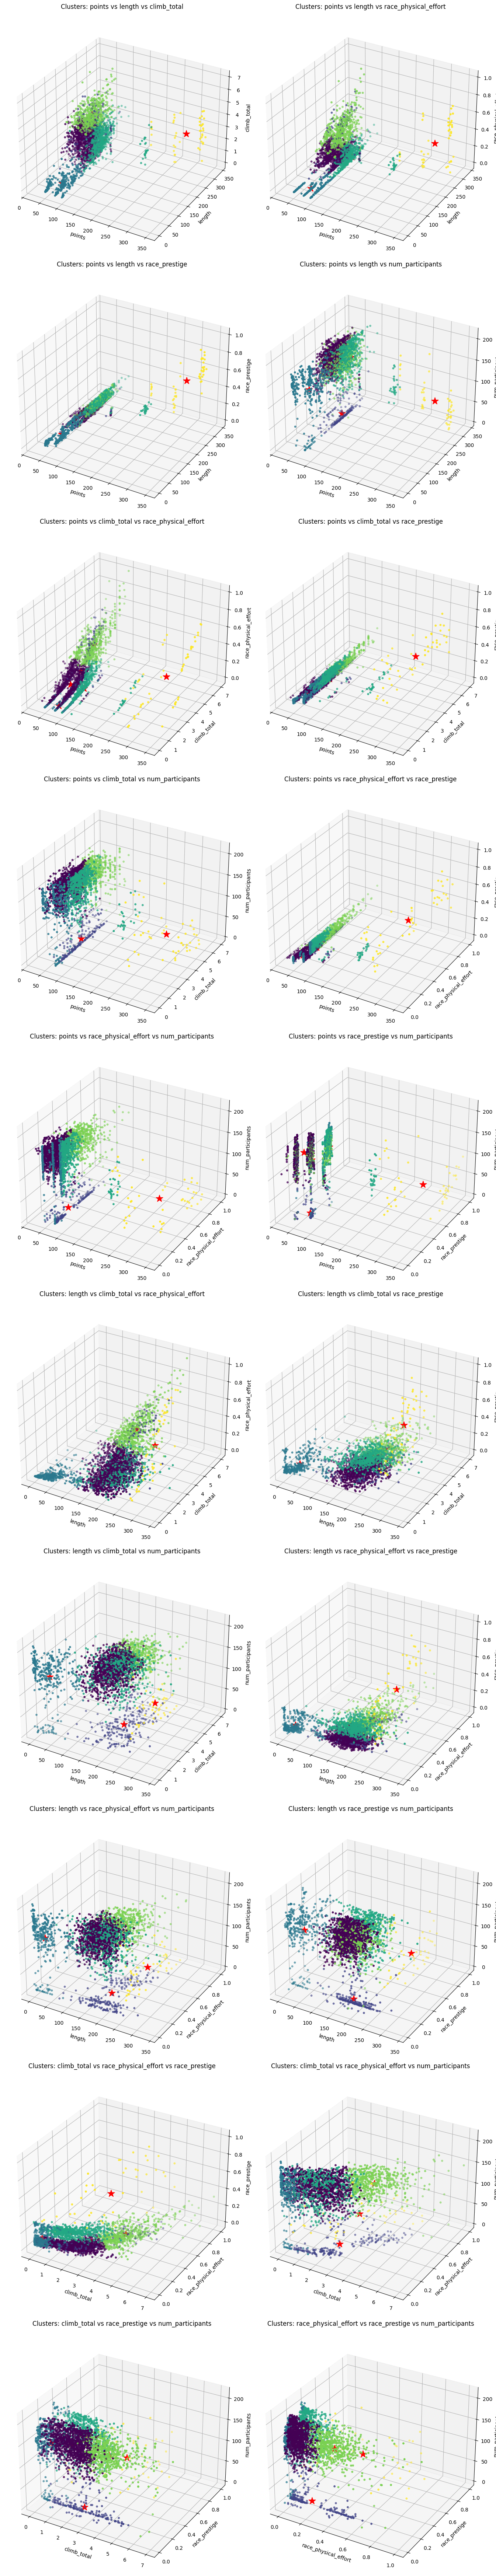

In [18]:
plot_variable_triplets(columns_to_use, races_dataset)

#### Last Results

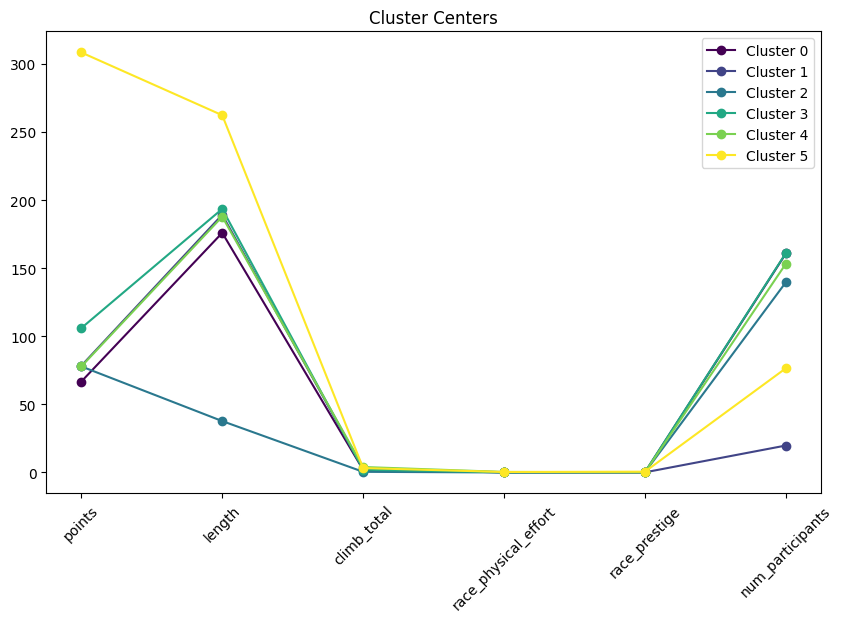

In [11]:
centers_original = scaler.inverse_transform(centers) # Centroids in the original scale
colors = plt.cm.viridis(np.linspace(0, 1, len(centers_original))) # Colors for the clusters

# Parallel visualization of the centroids
plt.figure(figsize=(10, 6))
for i in range(len(centers_original)):
    plt.plot(centers_original[i], marker='o', label=f'Cluster {i}', c=colors[i])
plt.xticks(range(len(columns_to_use)), columns_to_use, rotation=45)
plt.title('Cluster Centers')
plt.legend()
plt.show()

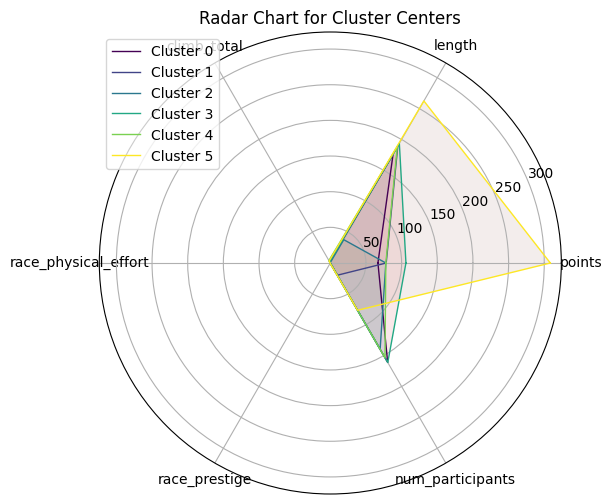

In [12]:
N = len(columns_to_use)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Radar Chart for each cluster
plt.figure(figsize=(10, 6))
for i, center in enumerate(centers_original):
    values = center.tolist()
    values += values[:1]
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}', c=colors[i])
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], columns_to_use)
plt.title('Radar Chart for Cluster Centers')
plt.legend()
plt.show()


In [14]:
centroid_df = pd.DataFrame(centers_original, columns=columns_to_use)
centroid_df

points      length  climb_total  race_physical_effort  race_prestige  \
0   66.764440  176.025975     1.978830              0.091621       0.095609   
1   78.364055  189.296774     2.648594              0.194792       0.102555   
2   77.897898   37.740781     0.472156              0.004811       0.145656   
3  106.051237  193.611837     2.027433              0.084390       0.259328   
4   77.842105  187.898070     4.007482              0.378940       0.139835   
5  308.510638  262.417872     3.232255              0.351537       0.587353   

   num_participants  
0        160.849278  
1         19.792627  
2        139.720721  
3        161.143110  
4        153.324561  
5         76.553191

To understand which features best define the clusters, we analyzed the 2D and 3D plots. By examining the values of the features and the centroids, we identified the key characteristics that differentiate the clusters. This analysis helps in interpreting the clustering results and understanding the underlying patterns in the data. Specifically, we observed that `race_prestige`, `race_physical_effort`, `length`, `climb_total`, `points`, and `num_participants` are the features with the highest correlation to the cluster separation.

In particular:
- **Cluster 0 (purple)** is characterized by medium-low values of `race_prestige` and `climb_total` (not too low), medium `length`, and high `num_participants`
- **Cluster 1 (blue)** is characterized by low values of `race_prestige` and `num_participants`, and medium `length`
- **Cluster 2 (light blue)** is characterized by low values of `length`, `climb_total` and `race_prestige`
- **Cluster 3 (aqua green)** is characterized by medium-low values of `race_prestige` and `climb_total` (not too low), medium `length`, and high `num_participants`
- **Cluster 4 (green)** is characterized by medium-low values of `race_prestige` (not too low), medium-high `climb_total` , medium `length`, and high `num_participants`
- **Cluster 5 (yellow)** is identified by high values of `points`, `length`, and `race_prestige`

In this case, most clusters are associated with more key features, and we mostly consider the values of `race_prestige`, `race_physical_effort`, and `climb_total`.
We can note that cluster 0 (purple), 3 (aqua green) and 4 (green), are determined with the `race_prestige`, `climb_total`, `length`, and `num_participants` features, and all of them are characterized with an high number of participants.
A caratteristic feature that separate the cluster 1 is the low value of `num_participants`, and the same is for the cluster 5 with the high `points`.